# **InfoShape Implementation** Bill Wu MEng '22
### MINE Code from my own fork: https://github.com/billywu1029/mine-pytorch
### Original: https://github.com/gtegner/mine-pytorch

Custom experiments using MINE as a mutual information estimator component in our overall privacy encoder scheme (https://docs.google.com/presentation/d/1GRT_qBQkLOu4eSxA32dAw3Z8A0psM40Eso_MllkyKX4/edit#slide=id.g11327204649_0_5).

MINE Paper: https://arxiv.org/pdf/1801.04062.pdf

ReMINE Paper: https://openreview.net/forum?id=Lvb2BKqL49a

Theory of MI Variational Bounds (Future Work Directions): https://arxiv.org/pdf/1905.06922.pdf

- Their google colab notebook: https://colab.research.google.com/github/google-research/google-research/blob/master/vbmi/vbmi_demo.ipynb


In [1]:
import os
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/My\ Drive//MIT/MEng/MINE/mine-pytorch
# !ls

print(os.getcwd())

/home/bill/Documents/mit/MEng/research/code-final/mine-pytorch


In [2]:
import torch

/home/bill/anaconda3/envs/60001/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mine.datasets import MultivariateNormalDataset

# !pip install pytorch_lightning
import pytorch_lightning

%load_ext tensorboard
from tqdm import tqdm
from mine.models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from torchsummary import summary

import torch.nn as nn
from torch.nn import functional as F

import time
import logging
logging.getLogger().setLevel(logging.ERROR)

from pytorch_lightning.loggers import TensorBoardLogger
from mine.models.mine import MutualInformationEstimator
from mine.datasets import load_dataloader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, RandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets
from torchvision.transforms import transforms

from sklearn.metrics import auc, roc_curve, roc_auc_score

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Set GPU Device and Set Seed

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)

seed = 1
seed_everything(seed, workers=True)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Numpy RNG
np.random.seed(seed)

Global seed set to 1


cpu


Constants

In [7]:
EXPERIMENT = "[GAUSSIAN | ENC TRAIN] REMINE BS=4K C=0 λ=0.1"
DIM = 10
N = 60000  # Size of the combined dataset, splitting by rho
MINE_BATCH_SIZE = 4000  # batch size for loading Gaussian dataset

# **Dataset Setup**

In [8]:
"""
Gaussian Dataset
DATA PROCESSING STEP
"""

class GaussianDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

torch.Size([48000, 20])
torch.Size([12000, 20])
torch.Size([12000])
tensor(6000.)


/home/bill/anaconda3/envs/60001/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


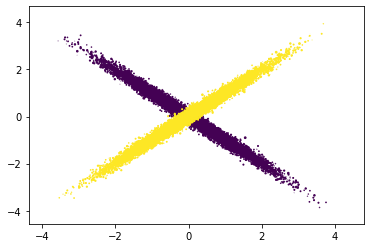

In [9]:
TRAIN_SIZE = int(N//2 * 0.8)
TEST_SIZE = int(N//2 * 0.2)

# See here for def'n of rho:
# https://gtas.unican.es/files/docencia/TICC/apuntes/tema1bwp_0.pdf
rho1 = -0.99
rho2 = 0.99

gaussian_train_rho1 = MultivariateNormalDataset(TRAIN_SIZE, DIM, rho1)
gaussian_train_rho2 = MultivariateNormalDataset(TRAIN_SIZE, DIM, rho2)
gaussian_test_rho1 = MultivariateNormalDataset(TEST_SIZE, DIM, rho1)
gaussian_test_rho2 = MultivariateNormalDataset(TEST_SIZE, DIM, rho2)

labels_train = torch.cat((torch.zeros(len(gaussian_train_rho1)), torch.ones(len(gaussian_train_rho2))), dim=0)
labels_test = torch.cat((torch.zeros(len(gaussian_test_rho1)), torch.ones(len(gaussian_test_rho2))), dim=0)

train_data = GaussianDataset(
    torch.cat((gaussian_train_rho1.x, gaussian_train_rho2.x), dim=0),
    labels_train
)
test_data = GaussianDataset(
    torch.cat((gaussian_test_rho1.x, gaussian_test_rho2.x), dim=0),
    labels_test
)

gaussian_train_loader = DataLoader(train_data, batch_size=MINE_BATCH_SIZE, shuffle=True)
gaussian_test_loader = DataLoader(test_data, batch_size=MINE_BATCH_SIZE, shuffle=True)
print(train_data.data.shape)
print(test_data.data.shape)
print(test_data.targets.shape)
print(test_data.targets.sum())
plt.scatter(train_data.data[:,0], train_data.data[:,DIM], train_data.data[:,DIM+1], c=train_data.targets)
plt.show()

In [10]:
train_data.data.shape

torch.Size([48000, 20])

In [ ]:
sampler = RandomSampler(train_data, replacement=True, num_samples=100 * MINE_BATCH_SIZE)
dl = DataLoader(train_data, sampler=sampler, batch_size=MINE_BATCH_SIZE)
for i, (x,y) in enumerate(dl):
    print(i, x.shape, y.shape)

In [ ]:
gaussian_train_rho1.cov_matrix

In [13]:
print(gaussian_train_rho1.true_mi)
print(gaussian_train_rho2.true_mi)

19.585182189941406
19.585182189941406


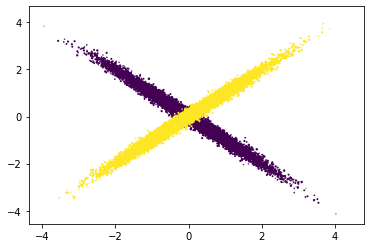

In [14]:
plt.scatter(train_data.data[:,0], train_data.data[:,DIM], train_data.data[:,2], c=train_data.targets)
plt.show()

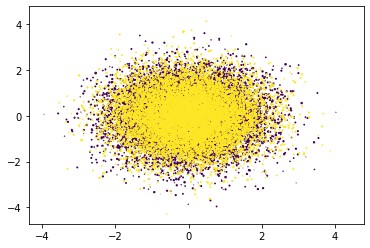

In [15]:
plt.scatter(train_data.data[:,0], train_data.data[:,1], train_data.data[:,2], c=train_data.targets)
plt.show()

# **Basic Classifier on Unencoded Gaussian Data**

In [16]:
class DenseClassifier(nn.Module):
    def __init__(self, in_nodes, hidden_nodes=100):
        super(DenseClassifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_nodes, hidden_nodes), 
            nn.ReLU(), 
            nn.Linear(hidden_nodes, 1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(device)
        return self.main(x)

def train_classifier(classifier, train_loader, epochs=100):
    optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-4, momentum=0.9)

    for epoch in tqdm(range(epochs)):
        classifier.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).float()
            y_hat = classifier(x).squeeze()
            loss = F.binary_cross_entropy(y_hat, y, reduction="sum")
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Average loss per image
        # If avg loss per pixel, divide again by inp_dim * inp_dim
        avg_train_loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')

def evaluate_classifier(classifier, test_loader):
    classifier.eval()
    test_data, test_labels = test_loader.dataset.data, test_loader.dataset.targets
    preds = classifier(test_data).squeeze()
    fpr, tpr, _ = roc_curve(test_labels.detach().cpu().numpy(), preds.detach().cpu().numpy())
    test_loss = F.binary_cross_entropy(preds, test_labels.to(device))
    print(test_loss.shape, test_loss)
    print(f"====> Test loss: {test_loss:.4f}")

    plt.plot(fpr, tpr, marker='.')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate' )
    plt.show()

In [17]:
model = DenseClassifier(2*DIM).to(device)
model

DenseClassifier(
  (main): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
train_classifier(model, gaussian_train_loader, epochs=500)

torch.Size([]) tensor(1.9451e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
====> Test loss: 0.0000


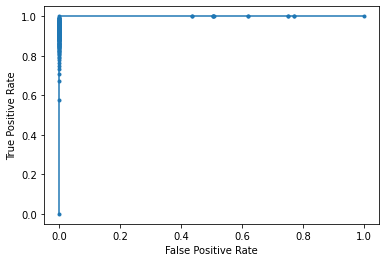

In [ ]:
evaluate_classifier(model, gaussian_test_loader)

# **Encoder Setup + Classifier on Encoded Outputs**

In [ ]:
class DenseEncoder(nn.Module):
    def __init__(self, in_dim, hidden_nodes=10, out_nodes=3):
        super(DenseEncoder, self).__init__()
        in_nodes = in_dim[0]
        self.out_nodes = out_nodes
        self.main = nn.Sequential(
            # Want 2 layers for more nonlinearity in the encoded data
            nn.Linear(in_nodes, hidden_nodes),
            nn.Tanh(),
            nn.Linear(hidden_nodes, out_nodes),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.to(device)
        return self.main(x)

In [ ]:
enc = DenseEncoder((2 * DIM,), out_nodes=3).to(device)
gaussian_train_transform = enc(train_data.data).detach()
gaussian_test_transform = enc(test_data.data).detach()
train_data_transform = GaussianDataset(
    gaussian_train_transform,
    labels_train
)
test_data_transform = GaussianDataset(
    gaussian_test_transform,
    labels_test
)

gaussian_train_loader_transform = DataLoader(train_data_transform, batch_size=MINE_BATCH_SIZE, shuffle=True)
gaussian_test_loader_transform = DataLoader(test_data_transform, batch_size=MINE_BATCH_SIZE, shuffle=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


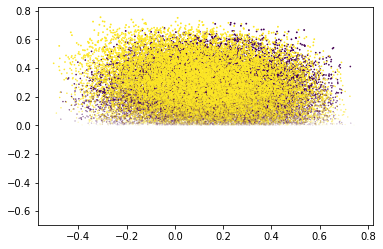

In [ ]:
plt.scatter(train_data_transform.data[:,1].detach().cpu(), train_data_transform.data[:,2].detach().cpu(), train_data_transform.data[:,2].detach().cpu(), c=labels_train)
plt.show()

In [ ]:
model_encoded = DenseClassifier(enc.out_nodes).to(device)
model_encoded

DenseClassifier(
  (main): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
train_classifier(model_encoded, gaussian_train_loader_transform, epochs=500)

torch.Size([]) tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
====> Test loss: 0.5976


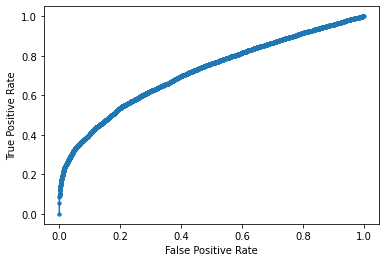

In [ ]:
evaluate_classifier(model_encoded, gaussian_test_loader_transform)

# **MINE Setup and Calculating I(x;x), I(x, z), I(z; L(x)), I(x; L(x))**

In [ ]:
from mine.models.mine import MutualInformationEstimator
from mine.models.mine import Mine

EXPERIMENT = "[GAUSSIAN] REMINE BS=4K C=0 λ=0.1 I(x;x)"

class MINEUtility(nn.Module):
    def __init__(self, enc_out_num_nodes):
        super().__init__()
        self.fc1 = nn.Linear(enc_out_num_nodes + 1, 100)  # named layer for debugging
        self.layers = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, z, labels):
        z, labels = z.float().to(device), labels.float().to(device)
        z = z.view(z.size(0), -1)
        cat = torch.cat((z, labels.unsqueeze(-1)), 1)
        return self.layers(cat)

class MINEPrivacy(nn.Module):
    def __init__(self, enc_out_num_nodes, x_num_nodes):
        super().__init__()
        self.fc1 = nn.Linear(enc_out_num_nodes + x_num_nodes, 100)  # named layer for debugging
        self.layers = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, z, x):
        z, x = z.float().to(device), x.float().to(device)
        z = z.view(z.size(0), -1)
        x = x.view(x.size(0), -1)

        cat = torch.cat((z, x), 1)
        return self.layers(cat)

### Prepare the dataset for I(x;x)

In [ ]:
train_data_HxCalc = GaussianDataset(train_data.data, train_data.data)
gaussian_train_loader_HxCalc = DataLoader(train_data_HxCalc, batch_size=MINE_BATCH_SIZE, shuffle=True)

### I(x;x) Lower Bound Estimate: MINE 1500 Iterations

In [ ]:
assert enc  # This should already be defined above
enc_out_num_nodes = 2*DIM
t = MINEPrivacy(enc_out_num_nodes, enc_out_num_nodes).to(device)
mi_estimator = Mine(t, loss='mine').to(device)
func_str = f"I(x;x) {enc_out_num_nodes} nodes"
lr = 1e-4
kwargs = {
    'mnist': True,
    'mine': mi_estimator,
    'lr': lr,
    'batch_size': MINE_BATCH_SIZE,
    'alpha': 0.1,
    'func': func_str,
    'train_loader': gaussian_train_loader_HxCalc,
    # Determines how many minibatches (MINE iters) of gradients get accumulated before optimizer step gets applied
    # Meant to stabilize the MINE curve for [hopefully] better encoder training performance
    'gradient_batch_size': 10
}

logger = TensorBoardLogger(
    "lightning_logs",
    name=f"{EXPERIMENT} privacy BS={MINE_BATCH_SIZE}",
    version=f"Gaussian: {func_str}, BS: {MINE_BATCH_SIZE}"
)

# Legacy params that should just be refactored out eventually
x_dim, z_dim = 1, 1
model = MutualInformationEstimator(
    x_dim, z_dim, loss='mine', **kwargs).to(device)

trainer = Trainer(max_epochs=1500, logger=logger, gpus=1)
trainer.fit(model)

### I(x;z)

In [ ]:
train_data_I_xz = GaussianDataset(train_data.data, gaussian_train_transform)
gaussian_train_loader_I_xz = DataLoader(train_data_I_xz, batch_size=MINE_BATCH_SIZE, shuffle=True)

In [ ]:
EXPERIMENT = "[GAUSSIAN] REMINE BS=4K C=0 λ=0.1 I(x;z)"
t = MINEPrivacy(enc.out_nodes, 2*DIM).to(device)
mi_estimator = Mine(t, loss='mine').to(device)
func_str = f"I(x;z) {enc.out_nodes} nodes"
lr = 1e-4
kwargs = {
    'mnist': True,
    'mine': mi_estimator,
    'lr': lr,
    'batch_size': MINE_BATCH_SIZE,
    'alpha': 0.1,
    'func': func_str,
    'train_loader': gaussian_train_loader_I_xz,
    # Determines how many minibatches (MINE iters) of gradients get accumulated before optimizer step gets applied
    # Meant to stabilize the MINE curve for [hopefully] better encoder training performance
    'gradient_batch_size': 10
}

logger = TensorBoardLogger(
    "lightning_logs",
    name=f"{EXPERIMENT} privacy BS={MINE_BATCH_SIZE}",
    version=f"Gaussian: {func_str}, BS: {MINE_BATCH_SIZE}"
)

# Legacy params that should just be refactored out eventually
x_dim, z_dim = 1, 1
model = MutualInformationEstimator(
    x_dim, z_dim, loss='mine', **kwargs).to(device)

trainer = Trainer(max_epochs=1500, logger=logger, gpus=1)
trainer.fit(model)

### I(z; L(x))

In [ ]:
gaussian_train_loader_I_zLx = gaussian_train_loader_transform

In [ ]:
EXPERIMENT = "[GAUSSIAN] REMINE BS=4K C=0 λ=0.1 I(z;L(x))"
t = MINEUtility(enc.out_nodes).to(device)
mi_estimator = Mine(t, loss='mine').to(device)
func_str = f"I(z;L(x)) {enc.out_nodes} nodes"
lr = 1e-4
kwargs = {
    'mnist': True,
    'mine': mi_estimator,
    'lr': lr,
    'batch_size': MINE_BATCH_SIZE,
    'alpha': 0.1,
    'func': func_str,
    'train_loader': gaussian_train_loader_I_zLx,
    # Determines how many minibatches (MINE iters) of gradients get accumulated before optimizer step gets applied
    # Meant to stabilize the MINE curve for [hopefully] better encoder training performance
    'gradient_batch_size': 10
}

logger = TensorBoardLogger(
    "lightning_logs",
    name=f"{EXPERIMENT} privacy BS={MINE_BATCH_SIZE}",
    version=f"Gaussian: {func_str}, BS: {MINE_BATCH_SIZE}"
)

# Legacy params that should just be refactored out eventually
x_dim, z_dim = 1, 1
model = MutualInformationEstimator(
    x_dim, z_dim, loss='mine', **kwargs).to(device)

trainer = Trainer(max_epochs=1000, logger=logger, gpus=1)
trainer.fit(model)

### I(x; L(x))

In [ ]:
EXPERIMENT = "[GAUSSIAN] REMINE BS=4K C=0 λ=0.1 I(x;L(x))"
t = MINEUtility(2*DIM).to(device)
mi_estimator = Mine(t, loss='mine').to(device)
func_str = f"I(x;L(x)) {2*DIM} nodes"
lr = 1e-4
kwargs = {
    'mnist': True,
    'mine': mi_estimator,
    'lr': lr,
    'batch_size': MINE_BATCH_SIZE,
    'alpha': 0.1,
    'func': func_str,
    'train_loader': gaussian_train_loader,
    # Determines how many minibatches (MINE iters) of gradients get accumulated before optimizer step gets applied
    # Meant to stabilize the MINE curve for [hopefully] better encoder training performance
    'gradient_batch_size': 10
}

logger = TensorBoardLogger(
    "lightning_logs",
    name=f"{EXPERIMENT} utility BS={MINE_BATCH_SIZE}",
    version=f"Gaussian: {func_str}, BS: {MINE_BATCH_SIZE}"
)

# Legacy params that should just be refactored out eventually
x_dim, z_dim = 1, 1
model = MutualInformationEstimator(
    x_dim, z_dim, loss='mine', **kwargs).to(device)

trainer = Trainer(max_epochs=1000, logger=logger, gpus=1)
trainer.fit(model)

# **Training Encoder using ReMINE for Loss**
Putting it all together to get ReMINE estimates for I(z;L(x)) and I(x;z) to form objective function to train 2-layer dense encoder

In [ ]:
# TODO: Too tired to refactor all the 'mnist' prefixes to 'gaussian' in this code cell oops
from mine.models.mine import MutualInformationEstimator
from mine.models.mine import Mine

BETA = 100
EXPERIMENT = f"[GAUSSIAN DIFF RHO | ENC TRAIN | BETA={BETA}] REMINE BS=4K C=0 λ=0.1"
MINE_BATCH_SIZE = 4000  # batch size for loading Gaussian dataset

class DualOptimizationDenseEncoder(nn.Module):
    def __init__(self, data_loader, mine_epochs_privacy, mine_epochs_utility, enc_out_nodes=3, beta=BETA):
        super().__init__()
        self.encoder = DenseEncoder((2 * DIM,), out_nodes=enc_out_nodes).to(device)
        self.data_loader = data_loader
        self.mine_epochs_privacy = mine_epochs_privacy
        self.mine_epochs_utility = mine_epochs_utility
        print(f"Using beta: {beta}")
        self.beta = beta

    def get_MINE(self, transformed_data_loader, enc_out_num_nodes, mine_epochs, train_epoch, mode, K=MINE_BATCH_SIZE, gradient_batch_size=1, in_nodes=2*DIM):
        lr = 1e-4
        x_num_nodes = in_nodes
        t = None
        if mode == "privacy":
            t = MINEPrivacy(enc_out_num_nodes, x_num_nodes).to(device)
        elif mode == "utility":
            t = MINEUtility(enc_out_num_nodes).to(device)
        else:
            raise RuntimeError("Only I(f(x); x) privacy and I(f(x); L(x)) utility supported for MINE modes")
        mi_estimator = Mine(t, loss='mine').to(device)
        func_str = f"training epoch={train_epoch}: {mode} f(x)=DenseEnc(x) {enc_out_num_nodes} nodes"

        kwargs = {
            'mnist': True,
            'mine': mi_estimator,
            'lr': lr,
            'batch_size': K,
            'alpha': 0.1,
            'func': func_str,
            'train_loader': transformed_data_loader,
            # Determines how many minibatches (MINE iters) of gradients get accumulated before optimizer step gets applied
            # Meant to stabilize the MINE curve for [hopefully] better encoder training performance
            'gradient_batch_size': gradient_batch_size
        }

        logger = TensorBoardLogger(
            "lightning_logs",
            name=f"{EXPERIMENT} {mode} BS={K}",
            version=f"MNIST: {func_str}, BS: {K}"
        )

        # TODO: [REFACTOR] Legacy params needed to fill in MIEstimator init, not used in our MINE
        x_dim, z_dim = 1, 1
        model = MutualInformationEstimator(
            x_dim, z_dim, loss='mine', **kwargs).to(device)

        return model, logger

    def forward(self, epoch, num_batches_final_MI, include_privacy=True, include_utility=True, K=MINE_BATCH_SIZE, gradient_batch_size=1, usetransformedforentropy=0):
        # Get encoder transformed data
        transformedimgs = self.encoder(self.data_loader.dataset.data)
        # dataset_transform(self.data_loader, self.encoder, 1, (self.encoder.out_nodes, ), in_dims=(2*DIM, )).squeeze()
        labels = self.data_loader.dataset.targets

        mnist_fx_train_utility_detached = GaussianDataset(transformedimgs.detach(), labels.detach())
        mnist_fx_train_privacy_detached = GaussianDataset(transformedimgs.detach(), self.data_loader.dataset.data.detach())
        mnist_fx_train_loader_utility_detached = DataLoader(mnist_fx_train_utility_detached, K, shuffle=True)
        mnist_fx_train_loader_privacy_detached = DataLoader(mnist_fx_train_privacy_detached, K, shuffle=True)

        # Get MINE model (sitting in Pytorch lightning module)
        model_MINE_utility, logger_utility = self.get_MINE(
            mnist_fx_train_loader_utility_detached, self.encoder.out_nodes, self.mine_epochs_utility, epoch, mode='utility', K=K, gradient_batch_size=gradient_batch_size)
        model_MINE_privacy, logger_privacy = self.get_MINE(
            mnist_fx_train_loader_privacy_detached, self.encoder.out_nodes, self.mine_epochs_privacy, epoch, mode='privacy', K=K, gradient_batch_size=gradient_batch_size)

        # Optimize MINE estimate, "train" MINE
        save_path = "/content/drive/My Drive/MIT/MEng/MINE/mine-pytorch/models/"
        last_mi_utility = last_mi_privacy = 0
        if include_utility:
            trainer_utility = Trainer(max_epochs=self.mine_epochs_utility, logger=logger_utility, gpus=1)
            trainer_utility.fit(model_MINE_utility)
            # torch.save(model_MINE_utility.energy_loss.state_dict(), save_path + f"utilityMINEepoch={epoch}")

            ## -------- Calculate I(f(x); L(x)) estimate after MINE training ---------- ##
            # **IMPORTANT**: Use the non-detached og transformedimgs so that gradients are retained
            mnist_fx_train_utility = GaussianDataset(transformedimgs, labels.float())
            mnist_fx_train_loader_utility = DataLoader(mnist_fx_train_utility, K, shuffle=True)
            model_MINE_utility.energy_loss.to(device)
            sum_MI_utility = 0

            # Average MI across num_batches_final_MI batches to lower variance
            # Batches are K random samples from the dataset after all
            utility_it = iter(mnist_fx_train_loader_utility)
            for i in range(num_batches_final_MI):
                x, labels = next(utility_it)
                x.to(device)
                labels.to(device)
                sum_MI_utility += model_MINE_utility.energy_loss(x, labels)
                
            # # MINE loss = -1 * MI estimate since we are maximizing using gradient descent still
            last_mi_utility = -1 * sum_MI_utility / num_batches_final_MI

        if include_privacy:
            trainer = Trainer(max_epochs=self.mine_epochs_privacy, logger=logger_privacy, gpus=1)
            trainer.fit(model_MINE_privacy)
            # torch.save(model_MINE_privacy.energy_loss.state_dict(), save_path + f"privacyMINEepoch={epoch}")

            ## -------- Calculate I(f(x); x) estimate after MINE training ---------- ##
            # **IMPORTANT**: Use the non-detached og transformedimgs so that gradients are retained
            mnist_fx_train_privacy = GaussianDataset(transformedimgs, self.data_loader.dataset.data)
            mnist_fx_train_loader_privacy = DataLoader(mnist_fx_train_privacy, K, shuffle=True)
            model_MINE_privacy.energy_loss.to(device)

            # Average MI across num_batches_final_MI batches to lower variance
            # Batches are K random samples from the dataset after all
            sampler = RandomSampler(
                mnist_fx_train_loader_privacy.dataset, 
                replacement=True, 
                num_samples=num_batches_final_MI *K
            )
            final_mi_dl = DataLoader(mnist_fx_train_loader_privacy.dataset, sampler=sampler, batch_size=K)
            sum_MI_privacy = 0
            for i, (fx,x) in enumerate(final_mi_dl):
                fx.to(device)
                x.to(device)
                mi = model_MINE_privacy.energy_loss(fx, x)
                sum_MI_privacy += mi

            # privacy_it = iter(mnist_fx_train_loader_privacy)
            # prev_mi = None
            # for i in range(num_batches_final_MI):
            #     fx, x = next(privacy_it)
            #     fx.to(device)
            #     x.to(device)
            #     mi = model_MINE_privacy.energy_loss(fx, x)
            #     assert mi != prev_mi, "Same MI estimates between final batches"
            #     prev_mi = mi
            #     sum_MI_privacy += mi
                
            # MINE loss = -1 * MI estimate since we are maximizing using gradient descent still
            last_mi_privacy = -1 * sum_MI_privacy / num_batches_final_MI

        return last_mi_utility, last_mi_privacy

    def train_encoder(
        self, 
        num_enc_epochs=10, 
        num_batches_final_MI=100, 
        save_enc_weights=False, 
        include_privacy=True, 
        include_utility=True,
        K=MINE_BATCH_SIZE,
        gradient_batch_size=1,
    ):
        # Encoder's training params
        learning_rate = 1e-3  # TODO: encoder can have a larger learning rate if we only have a few epochs right
        encoder_optimizer = torch.optim.Adam(
            self.encoder.parameters(),
            lr=learning_rate,
        )
        self.encoder.train()

        for epoch in range(num_enc_epochs):
            mi_utility, mi_privacy = self.forward(
                epoch, num_batches_final_MI, include_privacy=include_privacy, include_utility=include_utility, K=K, gradient_batch_size=gradient_batch_size
            )
            encoder_optimizer.zero_grad()
            # Normalize I(f(x); L(x)) against H(L(x)) and
            # normalize I(f(x); x) against H(x)
            H_Lx = 0.7  # Entropy of the Gaussian data
            H_x = 8  # TODO: This is just an estimate based on running ReMINE for I(x;x)

            # Since we're minimizing during gradient descent, but we want to
            # maximize this optimization function of I(f(x); L(x)) - I(f(x); x)
            # then we should minimize -1 * [ I(f(x); L(x)) - I(f(x); x) ]
            
            # loss = -1 * (mi_utility / H_Lx - self.beta * mi_privacy / H_x)
            loss = self.beta * mi_privacy / H_x
            loss.backward()
            encoder_optimizer.step()

            if save_enc_weights:
                # Don't save the state dict since that doesn't include the model
                # parameters + their gradients
                # Options were to save entire model or optimizer's state dict:
                # https://discuss.pytorch.org/t/how-to-save-the-requires-grad-state-of-the-weights/52906/6
                save_path = "/content/drive/My Drive/MIT/MEng/MINE/mine-pytorch/models/remine/"
                print(f"Saving weights to {save_path}")
                torch.save(self.encoder, save_path + f"{EXPERIMENT} epoch={epoch}.pt")
                torch.save(encoder_optimizer.state_dict(), save_path + f"[optimizer] {EXPERIMENT} epoch={epoch}.pt")

            print(f'====> Epoch: {epoch} Utility MI I(f(x); L(x)): {mi_utility:.8f}')
            print(f'====> Epoch: {epoch} Privacy MI I(f(x); x): {mi_privacy:.8f}')
            print(f'====> Epoch: {epoch} Loss: {loss:.8f}')

### Model Initialization

In [ ]:
BETA = 100
EXPERIMENT = f"[GAUSSIAN DIFF RHO | ENC TRAIN | TEST BETA={BETA}] REMINE BS=4K C=0 λ=0.1 100 final batches MI"
dualopt_model = DualOptimizationDenseEncoder(
    gaussian_train_loader, mine_epochs_privacy=2, mine_epochs_utility=0, enc_out_nodes=3
).to(device)
start = time.time()
dualopt_model.train_encoder(num_enc_epochs=1, num_batches_final_MI=10, include_utility=False, save_enc_weights=True, K=4000, gradient_batch_size=10)
print(f"Total time taken: {time.time() - start} s.")

In [ ]:
dualopt_model = DualOptimizationDenseEncoder(
    gaussian_train_loader, mine_epochs_privacy=1500, mine_epochs_utility=1000, enc_out_nodes=3
).to(device)
start = time.time()
dualopt_model.train_encoder(num_enc_epochs=10, num_batches_final_MI=10, save_enc_weights=True, K=4000, gradient_batch_size=10)
print(f"Total time taken: {time.time() - start} s.")

beta = 10000
only privacy I(x;z)
batches final MI = 100 since could be the case that between enc training epochs the final mi goes up and down due to just variance which prohibits reliable training

In [ ]:
BETA = 100
EXPERIMENT = f"[GAUSSIAN DIFF RHO | ENC TRAIN | ONLY I(x;z) BETA={BETA}] REMINE BS=4K C=0 λ=0.1 100 final batches MI"
dualopt_model = DualOptimizationDenseEncoder(
    gaussian_train_loader, mine_epochs_privacy=3000, mine_epochs_utility=0, enc_out_nodes=3
).to(device)
start = time.time()
dualopt_model.train_encoder(num_enc_epochs=10, num_batches_final_MI=100, include_utility=False, save_enc_weights=True, K=4000, gradient_batch_size=10)
print(f"Total time taken: {time.time() - start} s.")

Switching beta values
beta = 10
beta = 100

In [ ]:
BETA = 10
EXPERIMENT = f"[GAUSSIAN DIFF RHO | ENC TRAIN | BETA={BETA}] REMINE BS=4K C=0 λ=0.1"
dualopt_model = DualOptimizationDenseEncoder(
    gaussian_train_loader, mine_epochs_privacy=1500, mine_epochs_utility=1000, enc_out_nodes=3
).to(device)
start = time.time()
dualopt_model.train_encoder(num_enc_epochs=10, num_batches_final_MI=10, save_enc_weights=True, K=4000, gradient_batch_size=10)
print(f"Total time taken: {time.time() - start} s.")

In [ ]:
BETA = 100
EXPERIMENT = f"[GAUSSIAN DIFF RHO | ENC TRAIN | BETA={BETA}] REMINE BS=4K C=0 λ=0.1"
dualopt_model = DualOptimizationDenseEncoder(
    gaussian_train_loader, mine_epochs_privacy=2000, mine_epochs_utility=1000, enc_out_nodes=3
).to(device)
start = time.time()
dualopt_model.train_encoder(num_enc_epochs=10, num_batches_final_MI=10, save_enc_weights=True, K=4000, gradient_batch_size=10)
print(f"Total time taken: {time.time() - start} s.")

### Loss is only I(x;z)

In [ ]:
BETA = -1
EXPERIMENT = f"[GAUSSIAN DIFF RHO | ENC TRAIN | ONLY I(x;z) LOSS] REMINE BS=4K C=0 λ=0.1"
dualopt_model = DualOptimizationDenseEncoder(
    gaussian_train_loader, mine_epochs_privacy=2000, mine_epochs_utility=0, enc_out_nodes=3
).to(device)
start = time.time()
dualopt_model.train_encoder(num_enc_epochs=25, num_batches_final_MI=10, include_utility=False, save_enc_weights=True, K=4000, gradient_batch_size=10)
print(f"Total time taken: {time.time() - start} s.")

In [ ]:
BETA = -1
EXPERIMENT = f"[GAUSSIAN DIFF RHO | ENC TRAIN | ONLY -1*I(x;z) LOSS] REMINE BS=4K C=0 λ=0.1"
dualopt_model = DualOptimizationDenseEncoder(
    gaussian_train_loader, mine_epochs_privacy=2500, mine_epochs_utility=0, enc_out_nodes=3
).to(device)
start = time.time()
dualopt_model.train_encoder(num_enc_epochs=25, num_batches_final_MI=10, include_utility=False, save_enc_weights=True, K=4000, gradient_batch_size=10)
print(f"Total time taken: {time.time() - start} s.")

### Load Encoder Weights to Observe Encoded Gaussian

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


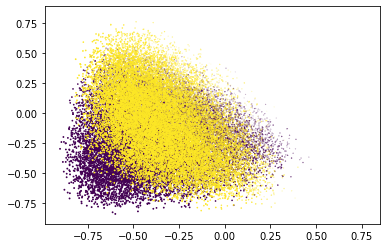

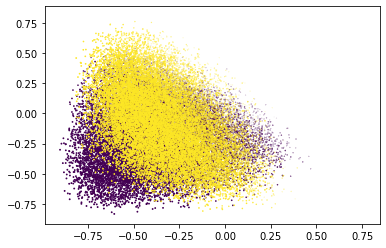

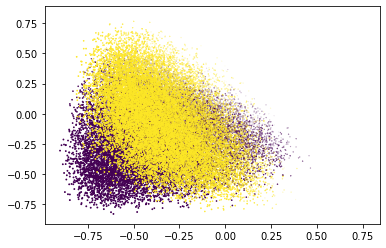

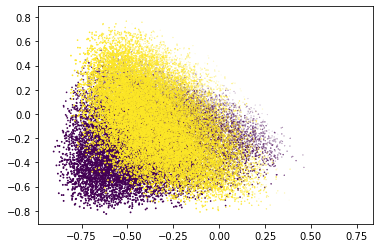

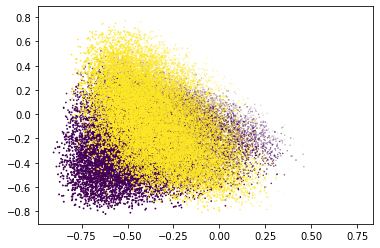

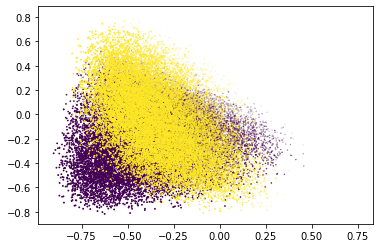

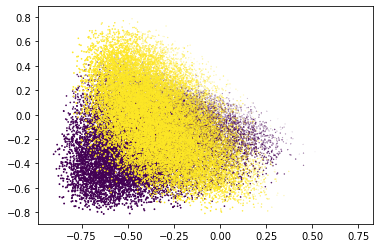

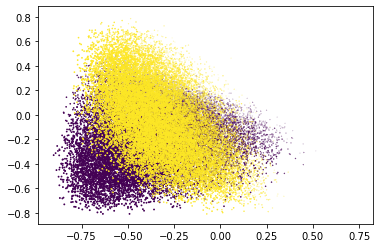

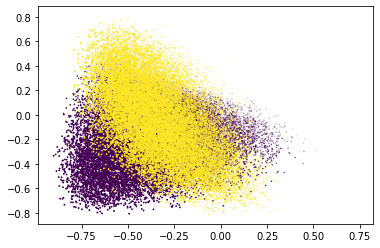

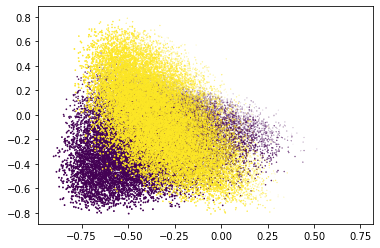

In [ ]:
save_path = "/content/drive/My Drive/MIT/MEng/MINE/mine-pytorch/models/remine/"
for epoch in range(10):
    enc_trained = torch.load(save_path + f"[GAUSSIAN DIFF RHO| ENC TRAIN] REMINE BS=4K C=0 λ=0.1 epoch={epoch}.pt")
    gaussian_train_transform_new = enc_trained(train_data.data).detach()
    train_data_transform_new = GaussianDataset(
        gaussian_train_transform_new,
        labels_train
    )
    plt.scatter(train_data_transform_new.data[:,0].detach().cpu(), train_data_transform_new.data[:,1].detach().cpu(), train_data_transform_new.data[:,2].detach().cpu(), c=labels_train)
    plt.show()
    plt.pause(0.01)

### Classification on Loaded Trained Encoder Outputs

In [ ]:
model_trainedenc = DenseClassifier(enc_trained.out_nodes).to(device)
model_trainedenc

DenseClassifier(
  (main): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
gaussian_train_loader_transform_new = DataLoader(train_data_transform_new, batch_size=MINE_BATCH_SIZE, shuffle=True)

In [ ]:
train_classifier(model_trainedenc, gaussian_train_loader_transform_new, epochs=500)

In [ ]:
gaussian_test_transform_new = enc_trained(test_data.data).detach()
test_data_transform_new = GaussianDataset(
    gaussian_test_transform_new,
    labels_test
)
gaussian_test_loader_transform_new = DataLoader(test_data_transform_new, batch_size=MINE_BATCH_SIZE, shuffle=True)

torch.Size([]) tensor(0.2882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
====> Test loss: 0.2882


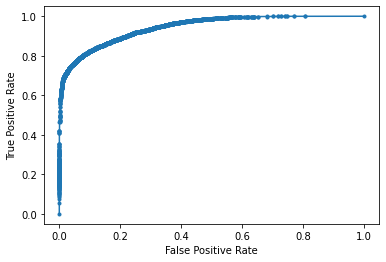

In [ ]:
evaluate_classifier(model_trainedenc, gaussian_test_loader_transform_new)

### Correlation as Loss

In [ ]:
"""
MNIST I(f(x); L(x)) Experiment with Convolutional MINE
TODO: I(x; f(x)) with Convolutional MINE

DATA PROCESSING STEP
"""

K=4000  # batch size for loading MNIST dataset
IMG_SIZE = 28

class MNISTTransformedDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

# Critical to have this as shuffle=False since it allows dataset_transform()
# to reproduce the same underlying MNIST dataset ordering each time
train_mnist_loader = load_dataloader('mnist', K, train=True, shuffle=False)
test_mnist_loader = load_dataloader('mnist', K, train=False, shuffle=False)

def dataset_transform(data_loader, encoder, out_chan, out_dims, in_dims=(IMG_SIZE, IMG_SIZE)):
    """
    Given a Pytorch data loader, return a torch tensor with every batch of the
    data loader's inputs transformed by the given encoder NN. The order of the
    data rows must be exactly the same order as the order found in the
    data loader (don't pass in a data loader with shuffle=True). 

    out_chan and out_dim are dimensions of the encoder output
    If encoder output is (bsize, 512, x, y) then out_chan=512, out_dim = (x,y)

    [BUG FIX] If out is np.zeros and constantly transferring between cpu & gpu, 
    there won't be any gradients saved after encoder transform, which is 
    critical for the later backprop steps in encoder training.               
    """
    assert isinstance(out_dims, tuple)
    out = torch.zeros((len(data_loader.dataset), out_chan, *out_dims)).to(device)

    curr_idx = 0
    for x, _ in data_loader:
        x = x.to(device).view(-1, 1, *in_dims)
        z = encoder(x)
        out[curr_idx: curr_idx + x.shape[0], :] = z

        # Increment by batch size each time to ensure correct indices
        curr_idx += x.shape[0]

    return out

NUM_EX = 1
EXPERIMENT = f"NEGATIVE CORRELATION TRAINING ENC FIRST {NUM_EX} IMGS"

class DenseEncoder(nn.Module):
    def __init__(self, in_dim, out_nodes=100):
        super(DenseEncoder, self).__init__()
        in_nodes = torch.prod(torch.tensor(in_dim))
        self.out_nodes = out_nodes
        self.out_dim = int(np.sqrt(out_nodes))
        assert self.out_dim ** 2 == out_nodes
        self.main = nn.Sequential(
            nn.Linear(in_nodes, out_nodes),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1).to(device)
        return self.main(x).view(-1, 1, self.out_dim, self.out_dim)

class DualOptimizationDenseEncoder(nn.Module):
    def __init__(self, data_loader, enc_out_nodes=300):
        super().__init__()
        self.encoder = DenseEncoder((IMG_SIZE * IMG_SIZE), out_nodes=enc_out_nodes).to(device)
        self.data_loader = data_loader

    def train_encoder(self, num_enc_epochs=10, save_enc_weights=False):
        # Encoder's training params
        learning_rate = 1e-3  # TODO: encoder can have a larger learning rate if we only have a few epochs right
        encoder_optimizer = torch.optim.Adam(
            self.encoder.parameters(),
            lr=learning_rate,
        )
        self.encoder.train()

        for epoch in range(num_enc_epochs):
            encoder_optimizer.zero_grad()
            transformedimgs = dataset_transform(self.data_loader, self.encoder, 1, (self.encoder.out_dim, self.encoder.out_dim))
            corr = torch.corrcoef(torch.stack((train_mnist_loader.dataset.data[:NUM_EX].to(device).flatten(), transformedimgs[:NUM_EX].flatten())))
            print(corr)
            loss = -1 * corr[0][1]  # Take the non-diagonal value (ie covar between og imgs and transformed imgs)
            loss.backward()
            encoder_optimizer.step()

            if save_enc_weights:
                # Don't save the state dict since that doesn't include the model
                # parameters + their gradients
                # Options were to save entire model or optimizer's state dict:
                # https://discuss.pytorch.org/t/how-to-save-the-requires-grad-state-of-the-weights/52906/6
                save_path = "/content/drive/My Drive/MIT/MEng/MINE/mine-pytorch/models/corr/"
                print(f"Saving weights to {save_path}")
                torch.save(self.encoder, save_path + f"{EXPERIMENT} epoch={epoch}.pt")
                # torch.save(encoder_optimizer.state_dict(), save_path + f"[optimizer] {EXPERIMENT} epoch={epoch}.pt")

            if epoch % 5 == 0 or epoch < 5:
                plt.imshow(transformedimgs[0].detach().cpu().numpy().squeeze())
                plt.show()

            print(f'====> Epoch: {epoch} Loss: {loss:.8f}')

In [ ]:
enc = DenseEncoder((IMG_SIZE * IMG_SIZE), out_nodes=784).to(device)
transformedimgs = dataset_transform(train_mnist_loader, enc, 1, (enc.out_dim, enc.out_dim))
transformedimgs.shape

torch.Size([60000, 1, 28, 28])

tensor([[1.0000, 0.0252],
        [0.0252, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


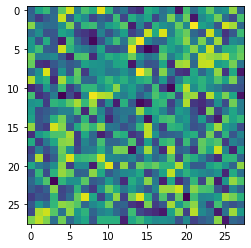

====> Epoch: 0 Loss: -0.02515014
tensor([[1.0000, 0.7329],
        [0.7329, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


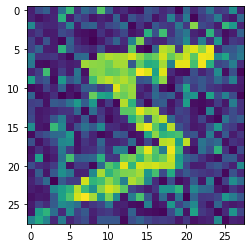

====> Epoch: 1 Loss: -0.73292637
tensor([[1.0000, 0.9193],
        [0.9193, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


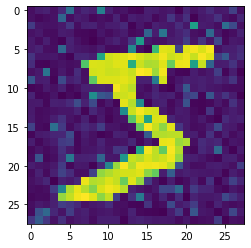

====> Epoch: 2 Loss: -0.91928798
tensor([[1.0000, 0.9560],
        [0.9560, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


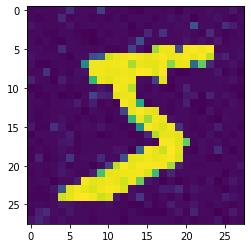

====> Epoch: 3 Loss: -0.95596844
tensor([[1.0000, 0.9657],
        [0.9657, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


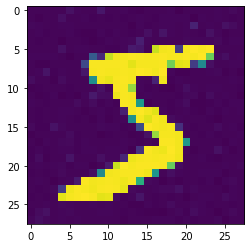

====> Epoch: 4 Loss: -0.96568727
tensor([[1.0000, 0.9699],
        [0.9699, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


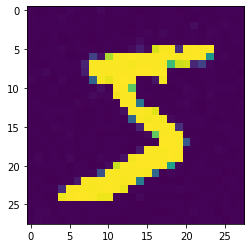

====> Epoch: 5 Loss: -0.96988708
tensor([[1.0000, 0.9714],
        [0.9714, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 6 Loss: -0.97144377
tensor([[1.0000, 0.9723],
        [0.9723, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 7 Loss: -0.97234243
tensor([[1.0000, 0.9726],
        [0.9726, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 8 Loss: -0.97262895
tensor([[1.0000, 0.9720],
        [0.9720, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 9 Loss: -0.97204900
tensor([[1.0000, 0.9719],
        [0.9719, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


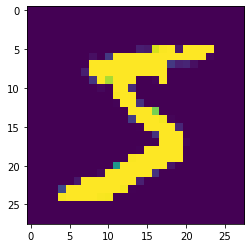

====> Epoch: 10 Loss: -0.97190613
tensor([[1.0000, 0.9723],
        [0.9723, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 11 Loss: -0.97232002
tensor([[1.0000, 0.9729],
        [0.9729, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 12 Loss: -0.97294772
tensor([[1.0000, 0.9733],
        [0.9733, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 13 Loss: -0.97333485
tensor([[1.0000, 0.9735],
        [0.9735, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 14 Loss: -0.97349638
tensor([[1.0000, 0.9737],
        [0.9737, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


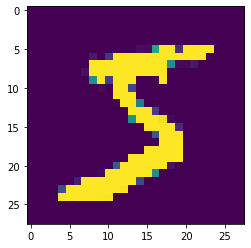

====> Epoch: 15 Loss: -0.97372115
tensor([[1.0000, 0.9741],
        [0.9741, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 16 Loss: -0.97405988
tensor([[1.0000, 0.9745],
        [0.9745, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 17 Loss: -0.97446442
tensor([[1.0000, 0.9748],
        [0.9748, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 18 Loss: -0.97483438
tensor([[1.0000, 0.9752],
        [0.9752, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 19 Loss: -0.97524381
tensor([[1.0000, 0.9758],
        [0.9758, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


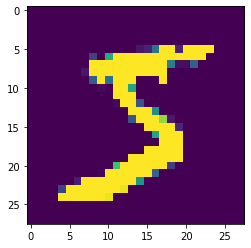

====> Epoch: 20 Loss: -0.97584444
tensor([[1.0000, 0.9765],
        [0.9765, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 21 Loss: -0.97653669
tensor([[1.0000, 0.9770],
        [0.9770, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 22 Loss: -0.97700477
tensor([[1.0000, 0.9771],
        [0.9771, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 23 Loss: -0.97706449
tensor([[1.0000, 0.9772],
        [0.9772, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 24 Loss: -0.97721052
tensor([[1.0000, 0.9778],
        [0.9778, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)


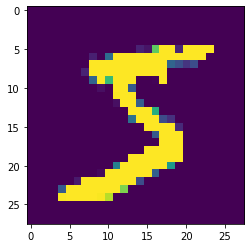

====> Epoch: 25 Loss: -0.97781271
tensor([[1.0000, 0.9787],
        [0.9787, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 26 Loss: -0.97866637
tensor([[1.0000, 0.9792],
        [0.9792, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 27 Loss: -0.97916317
tensor([[1.0000, 0.9791],
        [0.9791, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 28 Loss: -0.97911483
tensor([[1.0000, 0.9790],
        [0.9790, 1.0000]], device='cuda:0', grad_fn=<ClampBackward1>)
====> Epoch: 29 Loss: -0.97895277
Total time taken: 428.3336238861084 s.


In [ ]:
dualopt_model = DualOptimizationDenseEncoder(
    train_mnist_loader, enc_out_nodes=28*28  # same out dims as og imgs so that corr can be calculated
).to(device)
start = time.time()
# Want to save enc weights so we can test classification accuracy later, K=MINEbatchsize
dualopt_model.train_encoder(num_enc_epochs=30)
print(f"Total time taken: {time.time() - start} s.")

# Sandbox Experiment Verifying Dataloader Behavior
In particular, I'd like to sanity check:
- If we have shuffle=False in the og dataset, that the same ordering of datapoints is presented to us each time (assuming same seed)
- If shuffle=False og dataset and for dataset_transform we have shuffle=True, that they still iterate over the same data

In [ ]:
# TODO